## Imports

Below are the libraries and modules used in this project, including libraries for image processing (`PIL`), deep learning (`torch` and `torchvision`), and utilities like `tqdm` for progress bars and `mlflow` for tracking experiments.


In [11]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import torch.multiprocessing as mp
from models.cnn_model import Custom_CNN
from models.train import training
from torchsummary import summary
from torchvision.utils import make_grid
from utils.utils import display_images

### Device Setup

Determines the appropriate device for PyTorch operations. The device is chosen based on the availability of CUDA (NVIDIA GPUs) or MPS (Apple Silicon GPUs).
If neither is available, it defaults to the CPU.



In [12]:
device = (
    "cuda" if torch.cuda.is_available()
    
    # else "mps" if torch.backends.mps.is_available() 
    
    else "cpu"
)

device

'cpu'

# Data Augmentation & Transforms

In [13]:

train_transforms = transforms.Compose([
    transforms.Resize(size=(128, 128)),
   
    
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(degrees=15),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    # transforms.Normalize([0.5], [0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

#  Load Dataset

In [14]:
dataset_path = "../datasets/processed/Eyes_Dataset"
train_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, 'val'), transform=test_transforms)
test_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, 'test'), transform=test_transforms)


class_idx = train_dataset.class_to_idx
print(f"Index of classes are: {class_idx}")

class_names = list(class_idx)
print(f"\nClass Names are: {class_names}")


Index of classes are: {'Close_Eye': 0, 'Open_Eye': 1}

Class Names are: ['Close_Eye', 'Open_Eye']


# Create DataLoaders


In [15]:
BATCH_SIZE = 32
NUM_WORKERS = min(4, os.cpu_count())


train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    persistent_workers=True,
    pin_memory=True if device == "cuda" else False
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    persistent_workers=True,
    pin_memory=True if device == "cuda" else False
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    persistent_workers=True,
    pin_memory=True if device == "cuda" else False
)

# Visualizes

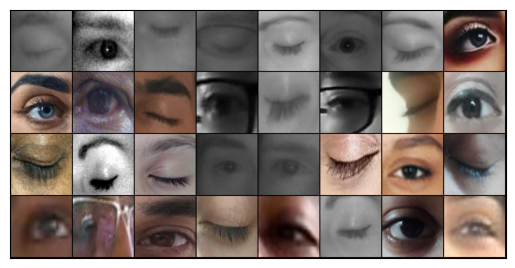

In [16]:
example_img = next(iter(train_dataloader))[0]
img_grid = make_grid(example_img)
display_images(img_grid)


# Initialize Model

In [17]:

model = Custom_CNN(
    input_shape=3,
    hidden_units=10, 
    output_shape=len(train_dataset.classes)
).to(device)
summary(model, input_size=(3, 128, 128), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 128, 128]             280
       BatchNorm2d-2         [-1, 10, 128, 128]              20
              ReLU-3         [-1, 10, 128, 128]               0
            Conv2d-4         [-1, 10, 128, 128]             910
       BatchNorm2d-5         [-1, 10, 128, 128]              20
              ReLU-6         [-1, 10, 128, 128]               0
         MaxPool2d-7           [-1, 10, 64, 64]               0
            Conv2d-8           [-1, 20, 64, 64]           1,820
       BatchNorm2d-9           [-1, 20, 64, 64]              40
             ReLU-10           [-1, 20, 64, 64]               0
           Conv2d-11           [-1, 20, 64, 64]           3,620
      BatchNorm2d-12           [-1, 20, 64, 64]              40
             ReLU-13           [-1, 20, 64, 64]               0
        MaxPool2d-14           [-1, 20,

# Training Configuration

In [18]:

EPOCHS = 5
LEARNING_RATE = 3e-4  

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer with weight decay
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=0.01,
    betas=(0.9, 0.999)
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Train the model

In [19]:

try:
    results = training(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        test_dataloader=test_dataloader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=EPOCHS,
        device=device,
        scheduler=scheduler,
        early_stopping_patience=5,
        experiment_name="EyeClassifier_v1"
    )
except KeyboardInterrupt:
    print("\033[33m Training interrupted by user!")
finally:
    # Cleanup
    for dataloader in [train_dataloader, val_dataloader, test_dataloader]:
        if hasattr(dataloader, '_iterator') and dataloader._iterator is not None:
            dataloader._iterator._shutdown_workers()


Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/301 [00:00<?, ?it/s]

Validation:   0%|          | 0/65 [00:00<?, ?it/s]

 
Epoch: 00 | Train Loss: 0.2798 | Train Acc: 0.8816 | Val Loss: 0.4693 | Val Acc: 0.7754 | LR: 0.000300
 Saved best model with accuracy: 0.7754


Training:   0%|          | 0/301 [00:00<?, ?it/s]

Validation:   0%|          | 0/65 [00:00<?, ?it/s]

 
Epoch: 01 | Train Loss: 0.1446 | Train Acc: 0.9468 | Val Loss: 0.3625 | Val Acc: 0.8613 | LR: 0.000271
 Saved best model with accuracy: 0.8613


Training:   0%|          | 0/301 [00:00<?, ?it/s]

Validation:   0%|          | 0/65 [00:00<?, ?it/s]

 
Epoch: 02 | Train Loss: 0.0971 | Train Acc: 0.9654 | Val Loss: 0.5044 | Val Acc: 0.8161 | LR: 0.000196


Training:   0%|          | 0/301 [00:00<?, ?it/s]

Validation:   0%|          | 0/65 [00:00<?, ?it/s]

 
Epoch: 03 | Train Loss: 0.0737 | Train Acc: 0.9744 | Val Loss: 0.6930 | Val Acc: 0.7937 | LR: 0.000104


Training:   0%|          | 0/301 [00:00<?, ?it/s]

Validation:   0%|          | 0/65 [00:00<?, ?it/s]

 
Epoch: 04 | Train Loss: 0.0542 | Train Acc: 0.9801 | Val Loss: 0.5013 | Val Acc: 0.8524 | LR: 0.000029
 Loaded best model with accuracy: 0.8613
 Running final evaluation on test set...


Testing:   0%|          | 0/65 [00:00<?, ?it/s]

 Final Test Loss: 0.3432
 Final Test Accuracy: 0.8680
